## Classifier for Parkison based on Tapping performance.


In [1]:
import pandas as pd
import json
import csv

In [2]:
#Save to a csv file

with open('TappingTableWithPerform&EntropyTap.csv') as csvfile:
    TapTable=pd.read_csv(csvfile, delimiter=',') 
with open('DemoTable.csv') as csvfile:
    DemoTable=pd.read_csv(csvfile, delimiter=',') 

In [3]:
TapTable['TapPerform'].min()

11

In [4]:
# eliminate the tasks where parkinson patients were feeling at their best
print(TapTable.shape)
TapTable=TapTable[TapTable['medTimepoint']!= 'Just after Parkinson medication (at your best)']
TapTable=TapTable[TapTable['medTimepoint']!= 'Another time']

#TapTable=TapTable.drop(['ROW_ID', 'ROW_VERSION','recordId','createdOn','appVersion','phoneInfo','accel_tapping.json.items','tapping_results.json.ButtonRectLeft','tapping_results.json.ButtonRectRight','tapping_results.json.endDate','tapping_results.json.startDate','tapping_results.json.TappingViewSize','medTimepoint'], axis=1)
print(TapTable.shape)

(69979, 18)
(44413, 18)


In [5]:
TapTable['healthCode'].nunique() 
#why is this number higher than the number of rows in DemoTable, which corresponds to the patients?

7355

In [6]:
# Averaging results over patients
TapTableN = TapTable.groupby("healthCode")["TapPerform","EntropyTap"].mean()
TapTableN = pd.DataFrame(TapTableN)  
TapTableN = TapTableN.reset_index()
print(TapTableN.head())



                             healthCode  TapPerform  EntropyTap
0  000240d1-1110-4dd2-a2d0-e344c37efd68       210.0    3.443919
1  0002d5ff-53da-44bb-ab0d-f2426a8c78e2       104.0    2.753290
2  0005a31d-e52c-447c-9971-ccc7bef667fb       180.0    2.898457
3  00081bd9-9abd-4003-b035-de6cc3e8c922        38.5    4.092585
4  00290381-e82e-46b2-b4e6-df115823d71b       193.0    3.422479


<ipython-input-6-b4dc841db553>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  TapTableN = TapTable.groupby("healthCode")["TapPerform","EntropyTap"].mean()


In [7]:
TapTableN.shape

(7355, 3)

In [8]:

#Sub-DataFrame of Demo Table with only features of interest: Age, diagnostic year, gender.
#DemoTable.head()
DemoTableN=DemoTable[["age","healthCode","diagnosis-year","gender"]]
DemoTableN.shape
DemoTableN= DemoTableN[DemoTableN['gender'] != 'Prefer not to answer']
#Merges TapTables with the PerfInfo and drops thos values in TapTable that are not defined in PerInfo
TapTableN=DemoTableN.merge(TapTableN)
TapTableN.shape
 



(6007, 6)

In [9]:
TapTableN=TapTableN.dropna(subset=['age','gender'])

In [10]:
DemoTableN.head()

,age,healthCode,diagnosis-year,gender
0,24.0,639e8a78-3631-4231-bda1-c911c1b169e5,NaN,Male
1,40.0,9295f618-177c-4676-b6aa-dc8419fd37ec,NaN,Male
2,38.0,52fe366a-2a9f-4260-9fb1-0fbc637a6cf4,NaN,Female
3,32.0,67bdd316-26fc-4fc7-8431-bf9f41a649dd,NaN,Male
4,48.0,45b4e2ca-8d15-4736-828c-829e3d4177f4,NaN,Male


In [11]:
# change gender column to categorical 0:female, 1: male
df_gender = pd.get_dummies(TapTableN['gender'],drop_first=True)
#print(TapTableN.gender.value_counts())
TapTableN = pd.concat([TapTableN, df_gender], axis=1)
TapTableN=TapTableN.drop(['healthCode','gender'], axis=1)



In [12]:
TapTableN.head()


,age,diagnosis-year,TapPerform,EntropyTap,Male
0,24.0,NaN,198.000000,3.410725,1
1,40.0,NaN,147.000000,3.202294,1
2,38.0,NaN,185.777778,3.015089,0
3,32.0,NaN,147.000000,3.415680,1
4,48.0,NaN,212.833333,2.805849,1


In [13]:
# diagnosis-year becomes years with diagnosed disease
TapTableN['diagnosis-year']=(2015-TapTableN['diagnosis-year'])
#NAN REPLACED WITH ZERO AND OTHER INT REPLACED WITH ONE
dfb = TapTableN['diagnosis-year'].notnull().astype(int)
TapTableN['YearsPD']=dfb
print(TapTableN)


       age  diagnosis-year  TapPerform  EntropyTap  Male  YearsPD
0     24.0             NaN  198.000000    3.410725     1        0
1     40.0             NaN  147.000000    3.202294     1        0
2     38.0             NaN  185.777778    3.015089     0        0
3     32.0             NaN  147.000000    3.415680     1        0
4     48.0             NaN  212.833333    2.805849     1        0
...    ...             ...         ...         ...   ...      ...
6002  64.0             1.0  263.000000    2.095113     1        1
6003  38.0             NaN  169.000000    3.881969     1        0
6004  61.0             2.0  213.196429    2.628523     1        1
6005  59.0             6.0   99.571429    4.203847     0        1
6006  56.0             1.0  128.000000    3.154038     0        1

[5957 rows x 6 columns]


In [14]:
X=TapTableN[['TapPerform', 'age','Male']]
y=TapTableN['YearsPD']
#Rename y 
y.head()

0    0
1    0
2    0
3    0
4    0
Name: YearsPD, dtype: int64

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

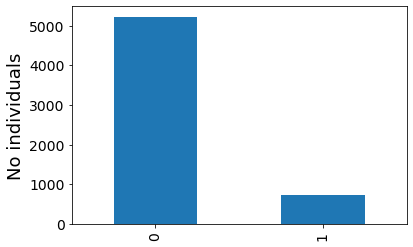

In [15]:
#y.loc[y.YearsPD == 0, 'YearsPD'] = 'Not Parkinsons'
#y.loc[y.YearsPD == 1, 'YearsPD'] = 'Parkinsons'
import matplotlib.pyplot as plt
PDPlot=y.value_counts().plot.bar()
PDPlot.set_ylabel('No individuals',fontsize=18)
#PDPlot.set_title('Audit Results')
PDPlot.set_xticklabels( ('0', '1'),fontsize=14 )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

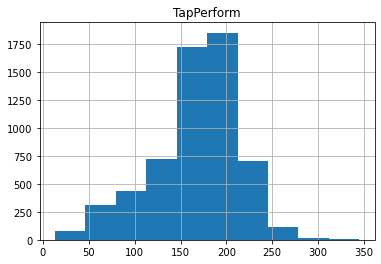

In [16]:
hist = X.hist(column='TapPerform')

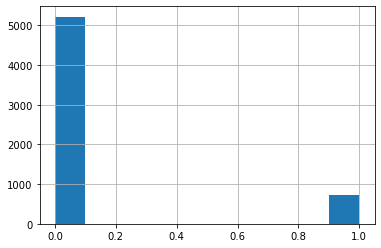

In [17]:
hist2=y.hist()

In [18]:
TapTableN['YearsPD'].isnull().values.any()
TapTableN['YearsPD'].value_counts()

0    5220
1     737
Name: YearsPD, dtype: int64

In [19]:
TapTableN

,age,diagnosis-year,TapPerform,EntropyTap,Male,YearsPD
0,24.0,NaN,198.000000,3.410725,1,0
1,40.0,NaN,147.000000,3.202294,1,0
2,38.0,NaN,185.777778,3.015089,0,0
3,32.0,NaN,147.000000,3.415680,1,0
4,48.0,NaN,212.833333,2.805849,1,0
...,...,...,...,...,...,...
6002,64.0,1.0,263.000000,2.095113,1,1
6003,38.0,NaN,169.000000,3.881969,1,0
6004,61.0,2.0,213.196429,2.628523,1,1
6005,59.0,6.0,99.571429,4.203847,0,1


<AxesSubplot:xlabel='TapPerform', ylabel='age'>

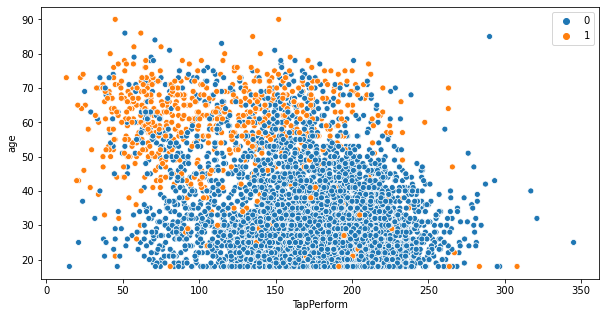

In [20]:
# scatter plot
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.scatterplot(data = TapTableN, 
                x = 'TapPerform', 
                y = 'age', 
                hue = TapTableN['YearsPD'].tolist())


# Building logistic regression model using weighted classifier

#### IMPORTANT NOTE: Here we use grid search that looks for the best weights for the classes. It is done trying each possible couple and doing cross validation. Using the metric as the AUC (for each weight tuple it creates an ROC curve ) The weighted class chosen (I think ) is the one that for a threshold of 0.5 gets the best point in the roc curve and has highest AUC.

##  Grid search to select best weight tuple

In [21]:
# define weight hyperparameter
w = [{0:1,1:1},{0:1,1:2},{0:1,1:3}, {0:1,1:4}, 
     {0:1,1:5}, {0:1,1:6}, {0:1,1:7}, {0:1,1:8}, 
     {0:1,1:9}, {0:1,1:10}, {0:1,1:12}, {0:1,1:14}, 
     {0:1,1:16}, {0:1,1:18}, {0:1,1:20}, 
     {0:1,1:25}, {0:1,1:30}, {0:1.0,1:40}, 
     {0:1.0,1:50}, {0:1,1:100}]
hyperparam_grid = {"class_weight": w }

In [22]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=13)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score

# define model
lg3 = LogisticRegression(random_state=13)
# define evaluation procedure
grid = GridSearchCV(lg3,hyperparam_grid,scoring="roc_auc", cv=None, n_jobs=-1, refit=True)
grid.fit(X_train,y_train)


GridSearchCV(estimator=LogisticRegression(random_state=13), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}, {0: 1, 1: 4},
                                          {0: 1, 1: 5}, {0: 1, 1: 6},
                                          {0: 1, 1: 7}, {0: 1, 1: 8},
                                          {0: 1, 1: 9}, {0: 1, 1: 10},
                                          {0: 1, 1: 12}, {0: 1, 1: 14},
                                          {0: 1, 1: 16}, {0: 1, 1: 18},
                                          {0: 1, 1: 20}, {0: 1, 1: 25},
                                          {0: 1, 1: 30}, {0: 1.0, 1: 40},
                                          {0: 1.0, 1: 50}, {0: 1, 1: 100}]},
             scoring='roc_auc')

In [24]:
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.9008032087171083 with param: {'class_weight': {0: 1, 1: 1}}


In [25]:
print(grid.cv_results_['mean_test_score'])

[0.90080321 0.90079443 0.90072407 0.90071318 0.90072643 0.9007264
 0.90069628 0.90063913 0.90055504 0.90054134 0.9004758  0.9004402
 0.90037772 0.90032078 0.90027182 0.90019561 0.90017102 0.90005726
 0.89982947 0.89927785]


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

### Best weighted class defined above

In [29]:
w = {0: 1.0, 1:1} #obtein from last 

classifierTap = LogisticRegression(class_weight=w)
classifierTap.fit(X_train, y_train) 

LogisticRegression(class_weight={0: 1.0, 1: 1})

Accuracy of logistic regression classifier on test set: 0.91
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1554
           1       0.76      0.50      0.60       234

    accuracy                           0.91      1788
   macro avg       0.84      0.74      0.78      1788
weighted avg       0.91      0.91      0.91      1788



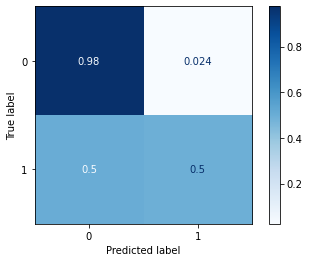

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

y_pred = classifierTap.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifierTap.score(X_test, y_test)))
confusionMatrix = confusion_matrix(y_test, y_pred, normalize='true')
print(classification_report(y_test, y_pred))
classes = ["unoccupied", "occupied"]
disp = plot_confusion_matrix(classifierTap, X_test, y_test,cmap=plt.cm.Blues,normalize='true')


Text(0.5, 1.0, 'ROC Curve ')

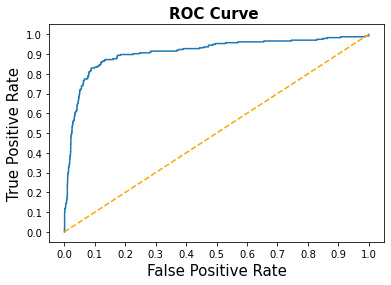

In [31]:
import matplotlib.pyplot as plt
import numpy as np
yproba = classifierTap.predict_proba(X_test)[::,1]
    
fpr, tpr, _ = roc_curve(y_test,  yproba)
auc = roc_auc_score(y_test, yproba)
plt.plot(fpr, tpr)
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve ', fontweight='bold', fontsize=15)



In [32]:
# test
y_pred = classifierTap.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.9133109619686801
Confusion Matrix: 
[[1517   37]
 [ 118  116]]
Area Under Curve: 0.735958485958486
Recall score: 0.49572649572649574


# 

In [116]:
a=classifierTap.predict([[400,35,36,1]])
a


array([0])

In [117]:
#'TapPerform', 'age','Male','EntropyTap'
print(classifierTap.coef_, classifierTap.intercept_)

[[-0.0090856   0.09447323 -0.51146332  0.54504272]] [-6.28366674]


# SVM classifier

In [119]:
from sklearn import metrics
from sklearn import svm
#Create a svm Classifier
clfSVM = svm.SVC(kernel='poly',probability=True) # 

#Train the model using the training sets
clfSVM.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clfSVM.predict(X_test)

In [120]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
yproba = clfSVM.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  yproba)
auc = roc_auc_score(y_test, yproba)

Accuracy: 0.9010067114093959


In [121]:
auc

0.8629579334902528

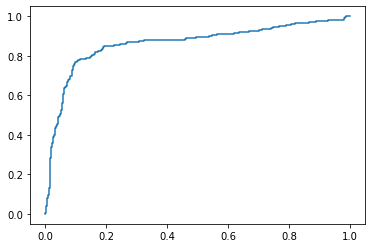

In [122]:
plt.plot(fpr, tpr)

In [123]:
import pickle
pickle_out = open("classifierTap.pkl","wb")
pickle.dump(classifierTap, pickle_out)
pickle_out.close()

# Checking whether non-linear classifiers do better

In [118]:
classifiers = [LogisticRegression(random_state=12), 
             RandomForestClassifier(random_state=12),
              svm.SVC(kernel='poly',probability=True,random_state=12)]


# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

NameError: name 'svm' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve ', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [ ]:
#Notes on the Report:
#Precision 0: TN/(TN+FN) of those predicted with out the disease, which how many really do not have it.
#Precision 1: TP/(TP+FP) of those predicted with the disease, which how many really had it.
#Recall 0: TN/(TN+FP) of those that dont have the disease how many were predicted with out the disease
#Recall 1: TP/(TP+FN) of those that have the disease how many were predicted with the disease
#Accuracy: TP+TN/(TP+TN+FP+FN), how many were classified correctly.
#For early diagnosis we would like to focus on recall 1 to be high. People with early stages of the disease should diagnose
#Few false negatives.

## Classifier for the app with all data set:¶

In [70]:
classTapApp = LogisticRegression(class_weight=w)
classTapApp.fit(X, y) 

LogisticRegression(class_weight={0: 1.0, 1: 1})

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5220
           1       0.68      0.51      0.58       737

    accuracy                           0.91      5957
   macro avg       0.81      0.74      0.76      5957
weighted avg       0.90      0.91      0.90      5957



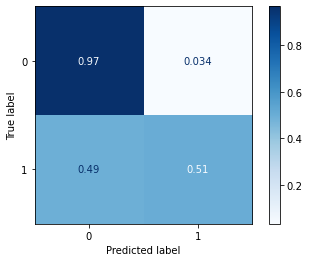

In [71]:
y_predAll = classTapApp.predict(X)
confusionMatrix = confusion_matrix(y, y_predAll, normalize='true')
print(classification_report(y, y_predAll))
disp = plot_confusion_matrix(classTapApp, X, y,cmap=plt.cm.Blues,normalize='true')


In [ ]:
#'TapPerform', 'age','Male'
a=classTapApp.predict([[200,60,1]])
a

In [ ]:
print(classTapApp.coef_,classTapApp.intercept_)

In [ ]:
import pickle
pickle_out = open("classTapApp.pkl","wb")
pickle.dump(classTapApp, pickle_out)
pickle_out.close()

In [ ]:
# Classification for each quantile
#import numpy as np
#from sklearn.linear_model import LogisticRegression
#from sklearn import metrics
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report
#from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import classification_report
#from sklearn.metrics import plot_confusion_matrix
#import matplotlib.pyplot as plt



#X = TapTableN[['TapPerform','age','Male','Prefer not to answer']].to_numpy()
##XTapPerf = np.reshape(XTapPerf, (-1,1))
#TapTableN['PDOn']= TapTableN['diagnosis-year']
#Y=TapTableN['PDOn'].to_numpy()
#Y[Y!=0] = 1
#print('Number of samples with the disease is: {:.2f}'.format(np.sum(Y)))
#print('Number of total samples: {:.2f}'.format(len(Y)))
##array_sum = np.sum(X)
##array_has_nan = np.isnan(array_sum)
##print(array_has_nan)
#X = X.astype(np.float64)
#Y = Y.astype(np.float64)
#X_train, X_test, y_train, y_test = train_test_split(X,Y , test_size=0.3, random_state=0)

#print(X)
#print(Y)
#print(y_train.shape)

#X_train = X_train.astype(np.float64)
#y_train = y_train.astype(np.float64)
#X_test = X_test.astype(np.float64)
#y_test = y_test.astype(np.float64)

#Training logistic regression
#logreg = LogisticRegression()
#logreg.fit(X_train, y_train)
#y_pred = logreg.predict(X_test)
#print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

#confusionMatrix = confusion_matrix(y_test, y_pred, normalize='true')
#print(confusionMatrix)
#print(classification_report(y_test, y_pred))
#disp = plot_confusion_matrix(logreg, X_test, y_test,cmap=plt.cm.Blues,normalize='true')


#Notes on the Report:
#Precision 0: TN/(TN+FN) of those predicted with out the disease, which how many really do not have it.
#Precision 1: TP/(TP+FP) of those predicted with the disease, which how many really had it.
#Recall 0: TN/(TN+FP) of those that dont have the disease how many were predicted with out the disease
#Recall 1: TP/(TP+FN) of those that have the disease how many were predicted with the disease
#Accuracy: TP+TN/(TP+TN+FP+FN), how many were classified correctly.
#For early diagnosis we would like to focus on recall 1 to be high. People with early stages of the disease should diagnose
#Few false negatives.

In [ ]:
##Plotting ROC Curve

##Calculate probabilities. Notice that this is different than evaluating the predict y_pred
#y_prob = logreg.predict_proba(X_test)
#y_prob1 = y_prob[:, 1]

#fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob1)
#roc_auc = metrics.auc(fpr, tpr)

#plt.title('Receiver Operating Characteristic')
#plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
#plt.show()

##Finding the best threshold
#print(threshold[np.argmax(tpr - fpr)])
#print(tpr[np.argmax(tpr - fpr)])
#print(fpr[np.argmax(tpr - fpr)])
#NewThrh=threshold[np.argmax(tpr - fpr)]
#y_probNew = (logreg.predict_proba(X_test)[:,1] >= NewThrh).astype(bool)
#from sklearn.metrics import accuracy_score
#accuracy_score(y_test, y_probNew)

## Using only people before taking medication


In [ ]:
#TapTableB = TapTableN[TapTableN['medTimepoint'] != "Just after Parkinson medication (at your best)"] 
#TapTableC = TapTableB[TapTableB['medTimepoint'] != "Another time"] 

#XX = TapTableC[['TapPerform','age','Male','Prefer not to answer']].to_numpy()
#YY=TapTableC['PDOn'].to_numpy()
#YY[YY!=0] = 1

#XX_train, XX_test, yy_train, yy_test = train_test_split(XX,YY , test_size=0.3, random_state=1)

##Training logistic regression
#logregC = LogisticRegression()
#logregC.fit(XX_train, yy_train)
#yy_predC = logregC.predict(XX_test)
#print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logregC.score(XX_test, yy_test)))
#confusionMatrixC = confusion_matrix(yy_test, yy_predC)
#print(confusionMatrixC)
#print(classification_report(yy_test, yy_predC))
#dispC = plot_confusion_matrix(logregC, XX_test, yy_test,cmap=plt.cm.Blues)



In [ ]:
#'TapPerform', 'age','Male'
a=classifierTap.predict([[100,40,0]])
a

In [ ]:
import seaborn as sns
sns.swarmplot(data=TapTableN, x="YearsPD", y="TapPerform")

In [ ]:
sns.swarmplot(data=TapTableN, x="YearsPD", y="age")

In [ ]:
#sns.swarmplot(data=TapTableN, x="YearsPD", y="Male")

In [ ]:
##Plotting ROC Curve

##Calculate probabilities. Notice that this is different than evaluating the predict y_pred
#y_probC = logregC.predict_proba(XX_test)
#y_prob1C = y_probC[:, 1]

#fprC, tprC, thresholdC = metrics.roc_curve(yy_test, y_prob1C)
#roc_aucC = metrics.auc(fprC, tprC)

#plt.title('Receiver Operating Characteristic')
#plt.plot(fprC, tprC, 'b', label = 'AUC = %0.2f' % roc_auc)
#plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
#plt.show()
##Saving this for using the new threshold
##y_pred = (clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool) # set threshold as 0.3
##print(fprC)
##print(fpr)

## Graph to see time dependency

In [ ]:
#Prob = logreg.predict_proba(X)
#ProbOfPD=Prob[:, 1]
#Ind=(TapTableN["diagnosis-year"]!=0)
#YearsPD=TapTableN["diagnosis-year"]
#nd=(YearsPD!=0)
#YearsPD[Ind]=(2015-YearsPD[Ind])
#plt.scatter(YearsPD, ProbOfPD, c="g", alpha=0.5, marker=r'$\clubsuit$',
#            label="Luck")
#plt.xlim([-0.5, 20])
#print(ProbOfPD[42])
#print(YearsPD[42])
##TapTableN["TimeDis"][Ind]=(2015-TapTableN["diagnosis-year"][Ind])
##print(TapTableN["age"][72])

In [ ]:
#'TapPerform', 'age','Male'
a=classifierTap.predict([[300,70,1]])
a
